In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)
from functions.model import GAN
import datetime
import json
from qiskit.circuit import ParameterVector
from functions.data_preperation import process_model_data
from functions.q_generator import two_qubit_circuit_tickers
from functions.model_test import plot_training_metrics, get_latest_model_path

In [4]:
model_directory ="models/"
latest_model_path = get_latest_model_path(model_directory)
#latest_model_path="models/models_2809.1230"

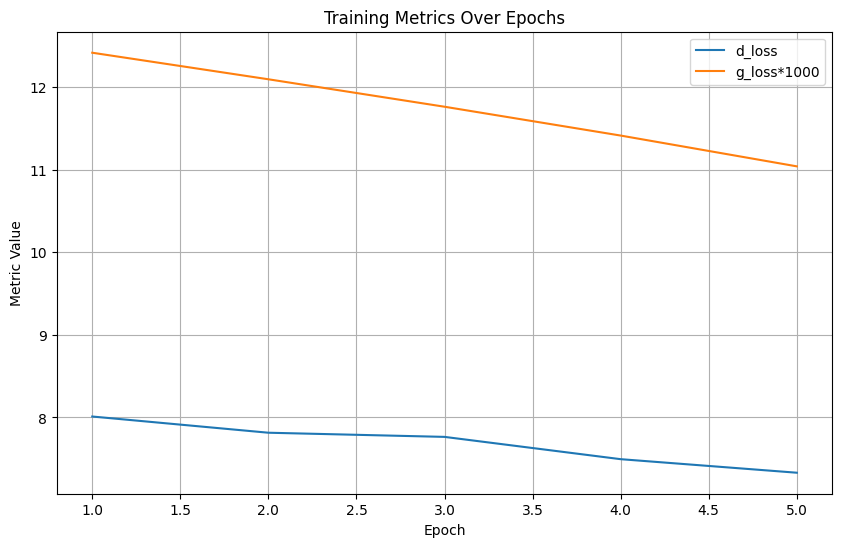

In [7]:
plot_training_metrics(f"{latest_model_path}/logs", generator_loss_scaling=1000)

In [8]:
targets = ["OC_next", "CO_next"]
features = ["Close", "High", "Low", "Open", "Volume", "MACD", "Signal_Line", "EMA_20"]
ticker = 'GOOG'

In [9]:
feature_data, target_data = process_model_data(targets, features, ticker) #feature_data, target_data

c:\Users\Jayde\Desktop\Projects\Schro-horse\functions\data_preperation.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


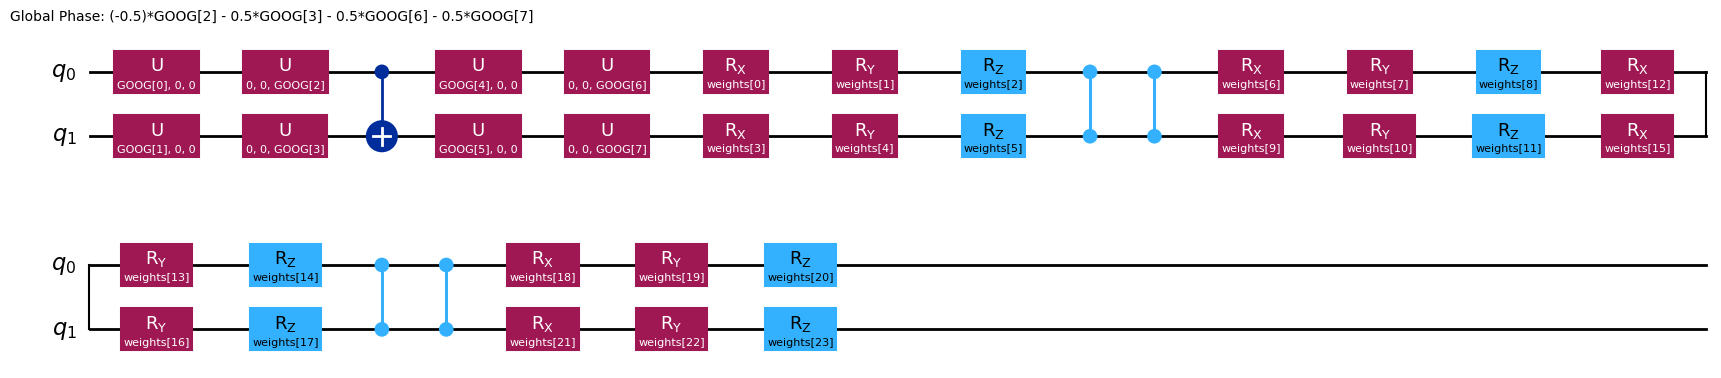

In [10]:
qc= two_qubit_circuit_tickers([ticker])
qc.draw('mpl')

## Loading weights into the model

In [12]:
#latest_model_path="models/models_2809.1018"
loaded_weights = np.load(f"{latest_model_path}/generator.npy")

In [13]:
param_vector = qc.parameters
param_list = list(param_vector)

In [14]:
# mapping from Parameters to values
weight_params=[param for param in param_list if param.name[:7]=="weights" ]
weight_param_dict = {param: val for param, val in zip(weight_params, loaded_weights)}

# Assign parameters to the circuit
qc_weighted = qc.assign_parameters(weight_param_dict)

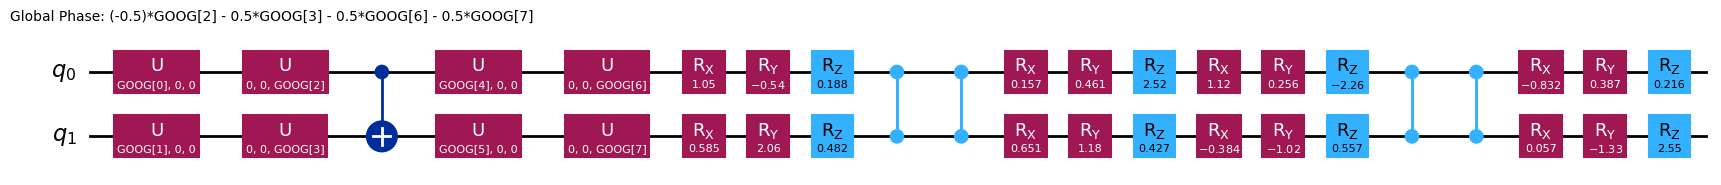

In [15]:
qc_weighted.draw('mpl')

### Encode data

In [23]:
#load in example data
input_data = feature_data[0]
data_param_list = list(qc_weighted.parameters)
data_param_dict = {param: val for param, val in zip(data_param_list, input_data)}

# Assign data encodings to the circuit
qc_data = qc_weighted.assign_parameters(data_param_dict)


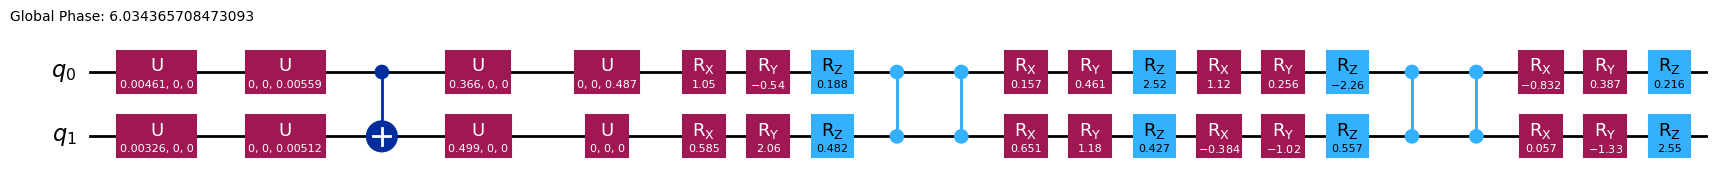

In [24]:
qc_data.draw('mpl')

### Run the circuit

In [25]:
from qiskit.quantum_info import SparsePauliOp
num_qubits = qc_data.num_qubits
observable = [SparsePauliOp.from_list([(f"{'I'*i}Z{'I'*(num_qubits-i-1)}", 1)]) for i in range(num_qubits)]

In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit import transpile

service = QiskitRuntimeService()
#backend = service.least_busy()
backend = GenericBackendV2(num_qubits=num_qubits)
qc_transpiled = transpile(qc_data, backend=backend, optimization_level=3)

estimator = EstimatorV2(mode=backend)

pub = (qc_transpiled, observable) #primitive unified bloc program input for estimator
job = estimator.run([pub])
result = job.result()[0]
expectation_values = result.data.evs

In [27]:
expectation_values

array([0.27880859, 0.88720703])

In [22]:
target_data[0]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.05264116,  0.2914946 ], dtype=float32)>